In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

#Sampling methods
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#feature engineering
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from boruta import BorutaPy

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

## Importing Data

In [2]:
train = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

# Data Cleansing

In [3]:
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0


In [5]:
train.shape

(1296675, 22)

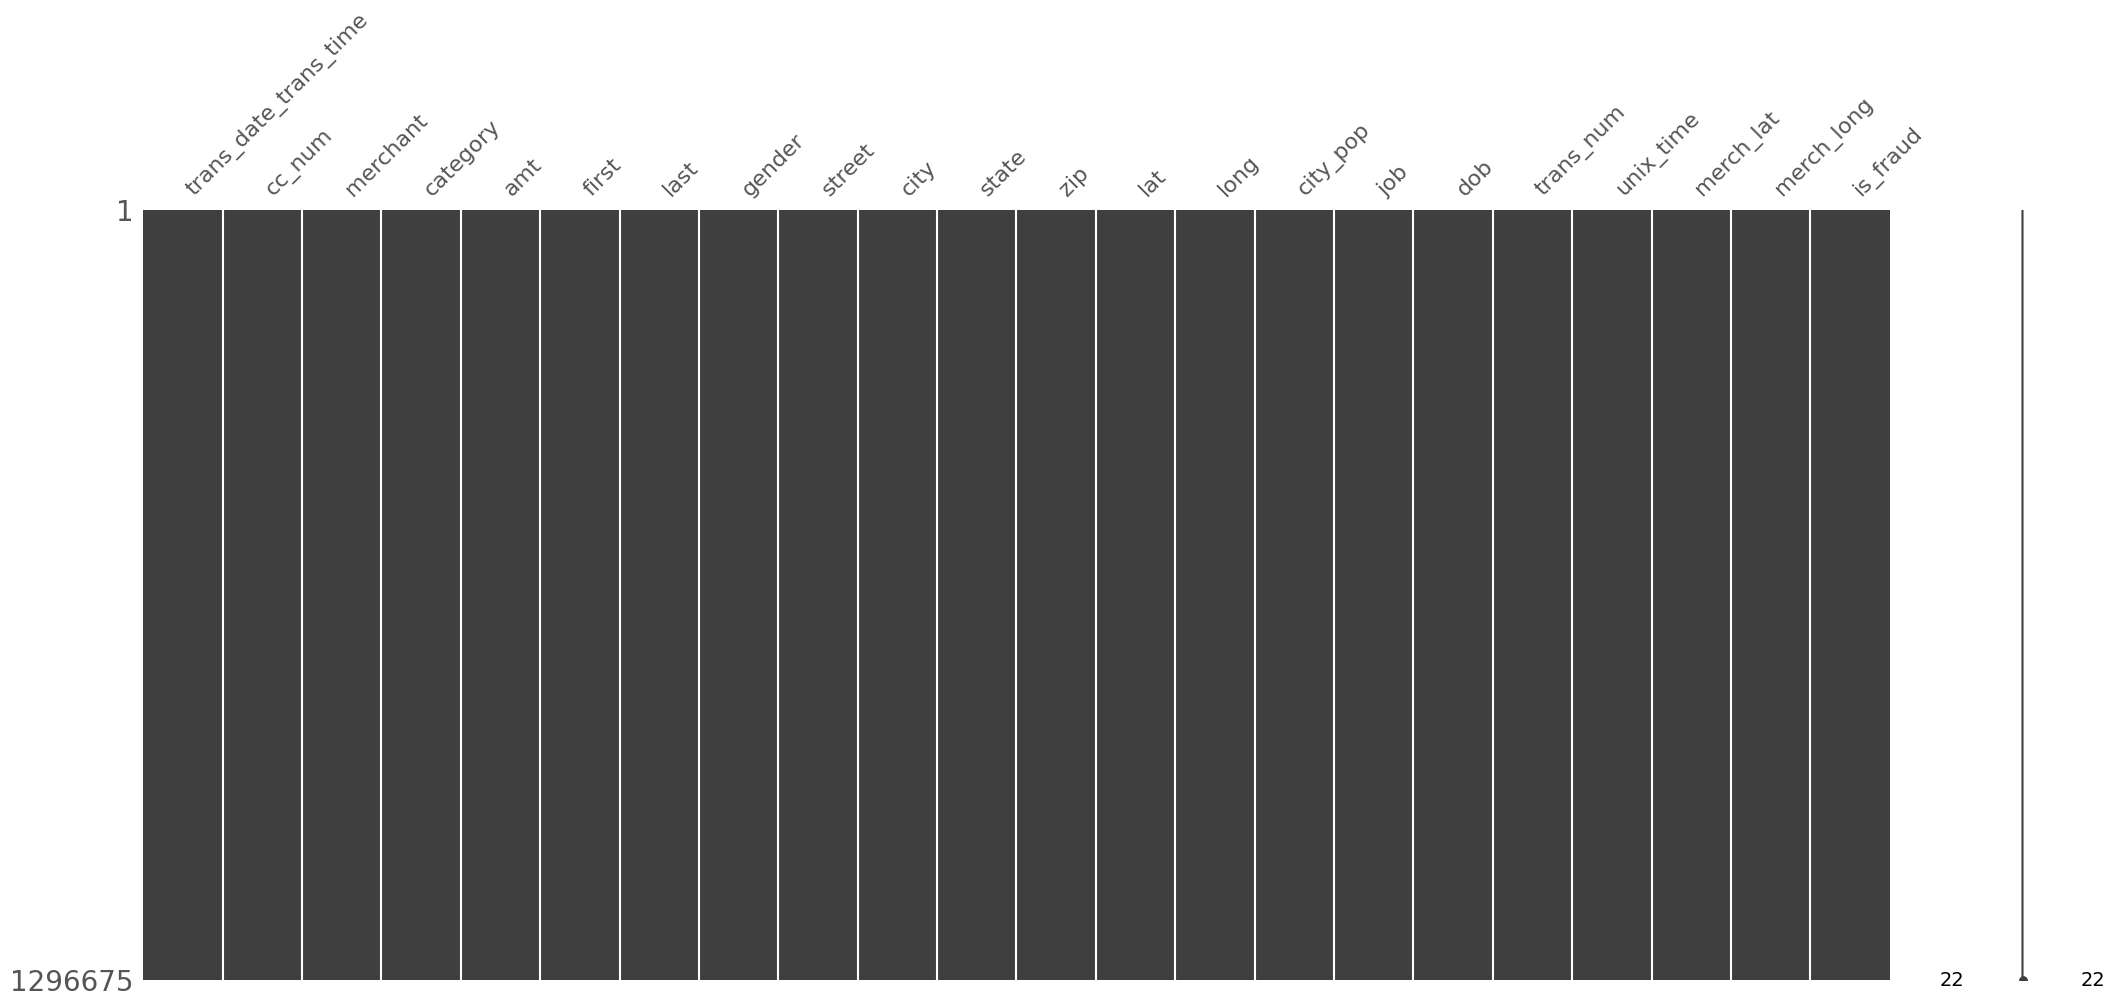

In [6]:
msno.matrix(train);

In [7]:
train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Exploratory Data Analysis (EDA)

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,240,384.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95
is_fraud,"1,296,675.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


In [4]:
train["amt"].describe()

count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

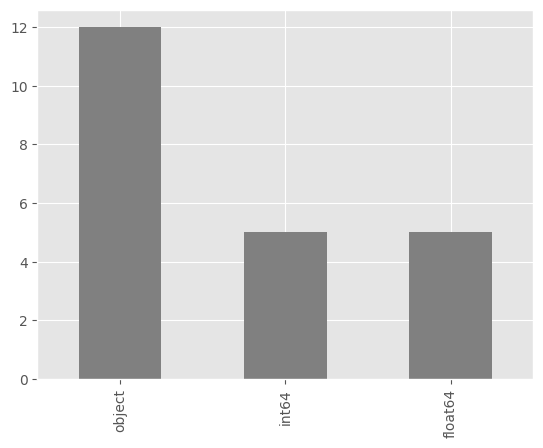

In [5]:
train.dtypes.value_counts().plot(kind='bar', color="grey");

## Univariate analysis

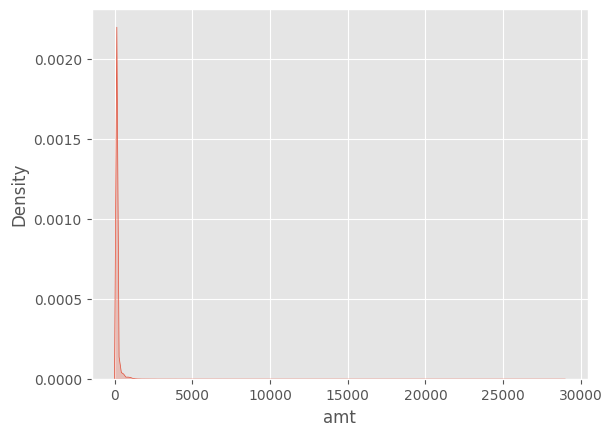

In [6]:
sns.kdeplot(train["amt"], fill=True);

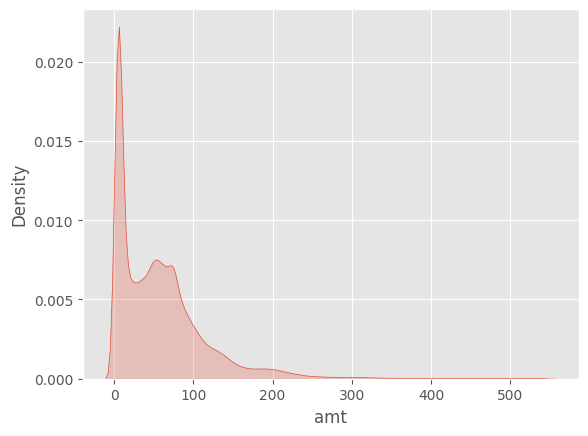

In [7]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);

## Multivariate analysis

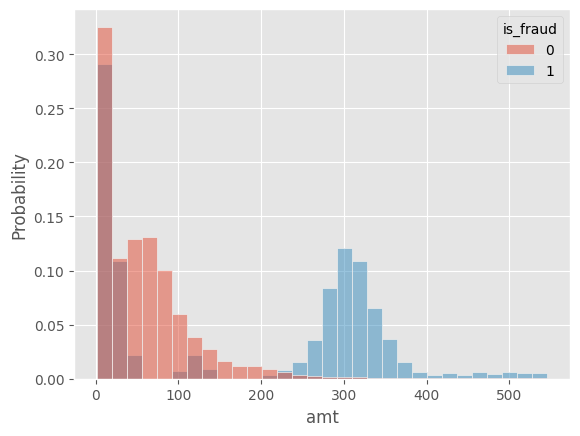

In [8]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= p99],
             common_norm=False);

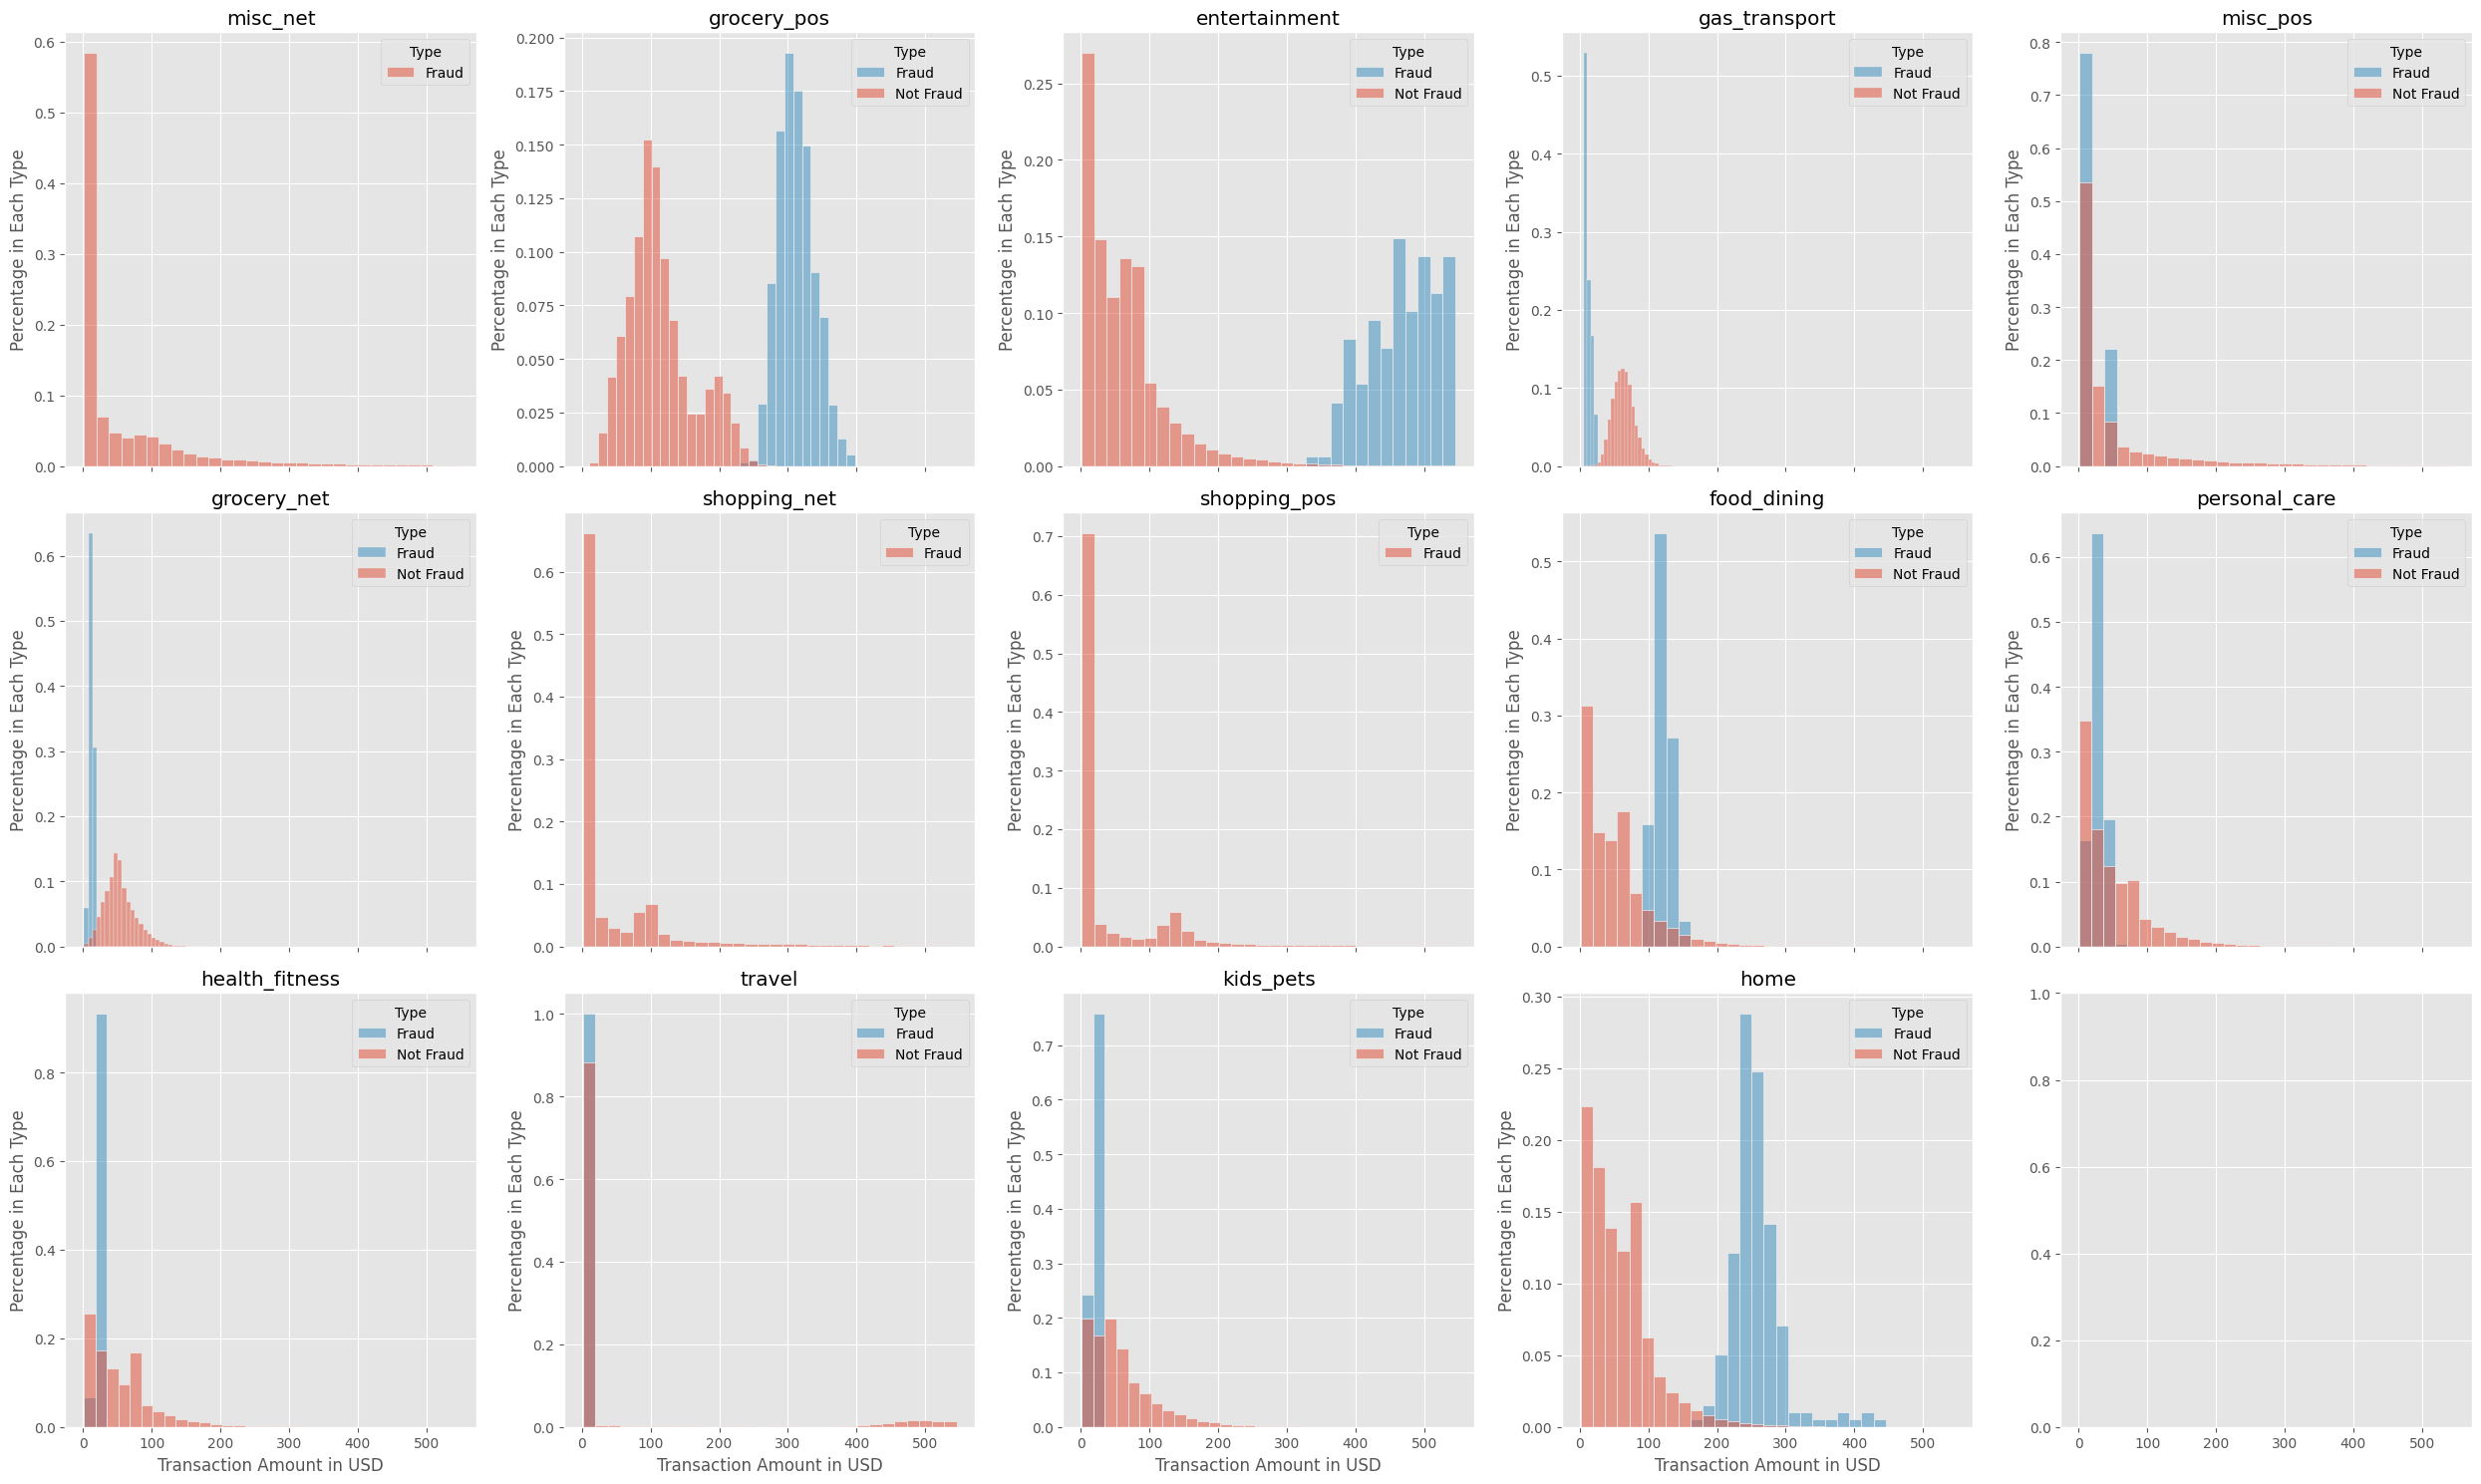

In [9]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

In [10]:
# non_fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.08,-0.02
1,home,0.10,0.03,-0.07
2,grocery_pos,0.09,0.23,0.14
3,shopping_pos,0.09,0.11,0.02
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.23,0.15
6,entertainment,0.07,0.03,-0.04
7,food_dining,0.07,0.02,-0.05
8,personal_care,0.07,0.03,-0.04
9,health_fitness,0.07,0.02,-0.05


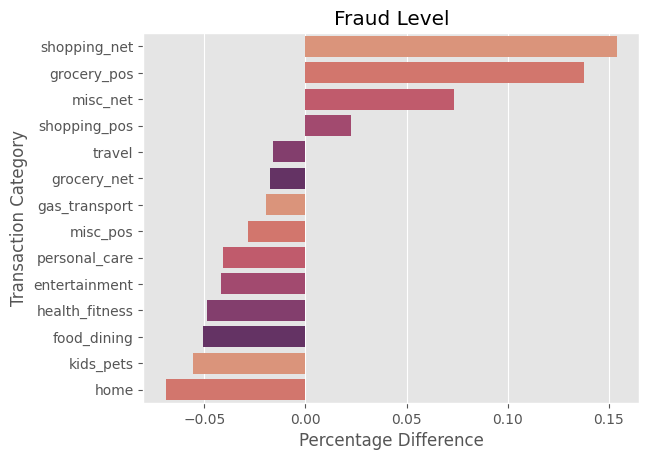

In [11]:
custom_palette = sns.color_palette("flare")
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

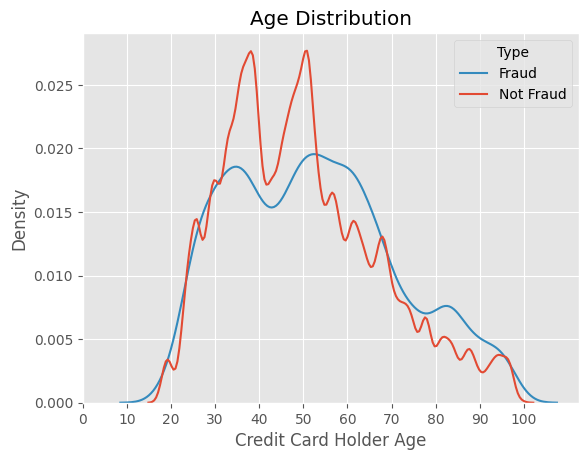

In [12]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

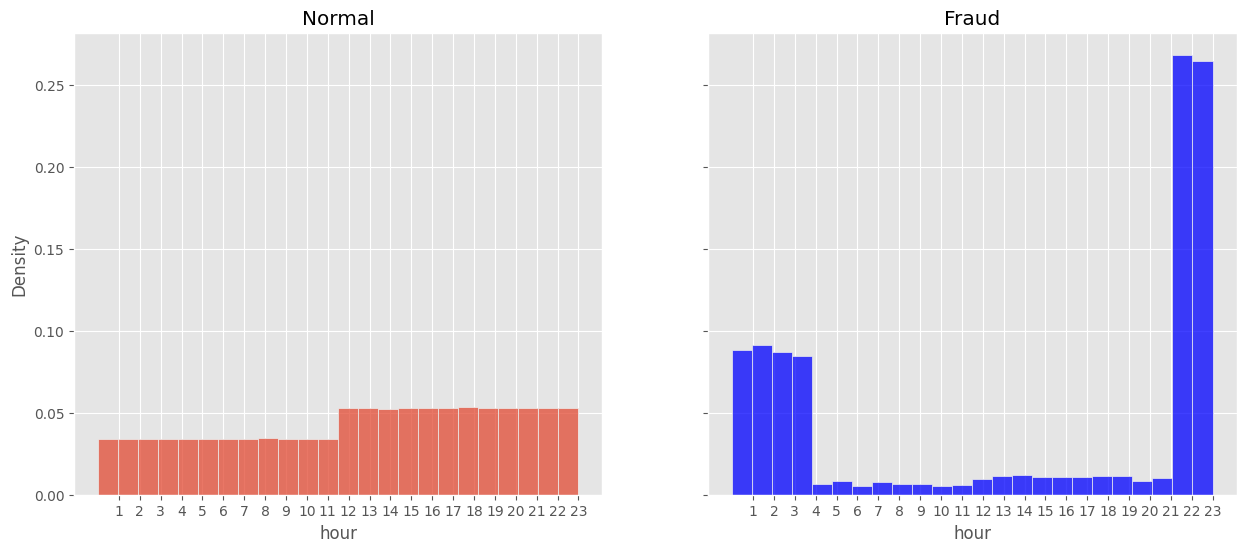

In [13]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

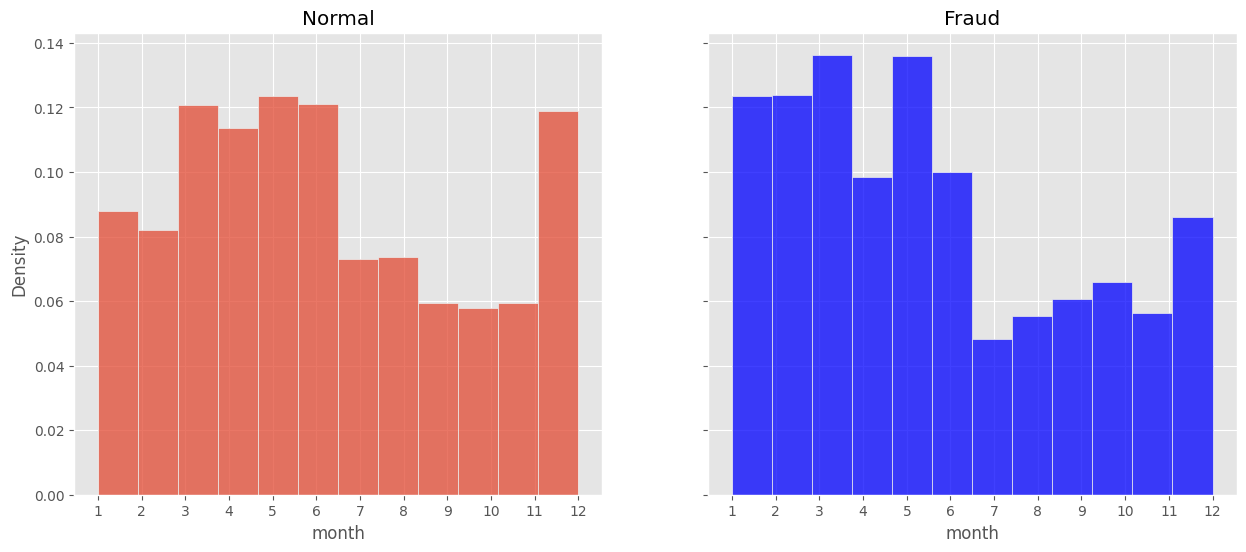

In [14]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

# Feature Engineering

In [15]:
train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [16]:
train.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,35,0,1
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,45,0,1


## Scaling

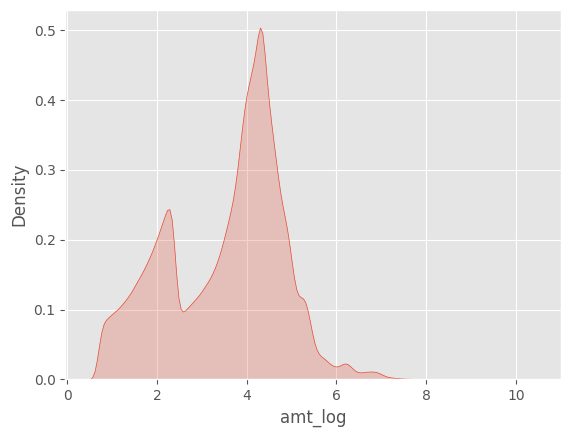

In [17]:
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True);

In [18]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


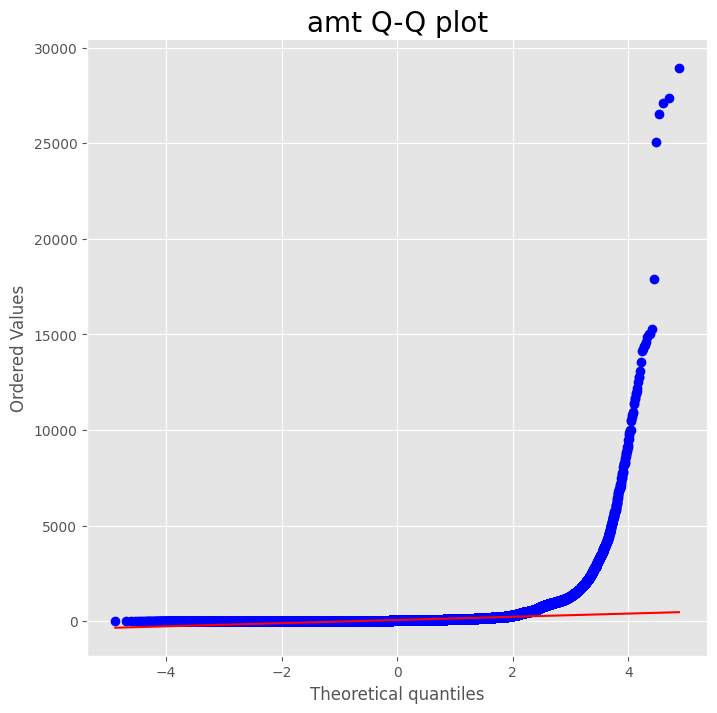

In [19]:
check_normality("amt");

amt_log : mean: 3.53, std: 1.29, skew: -0.30


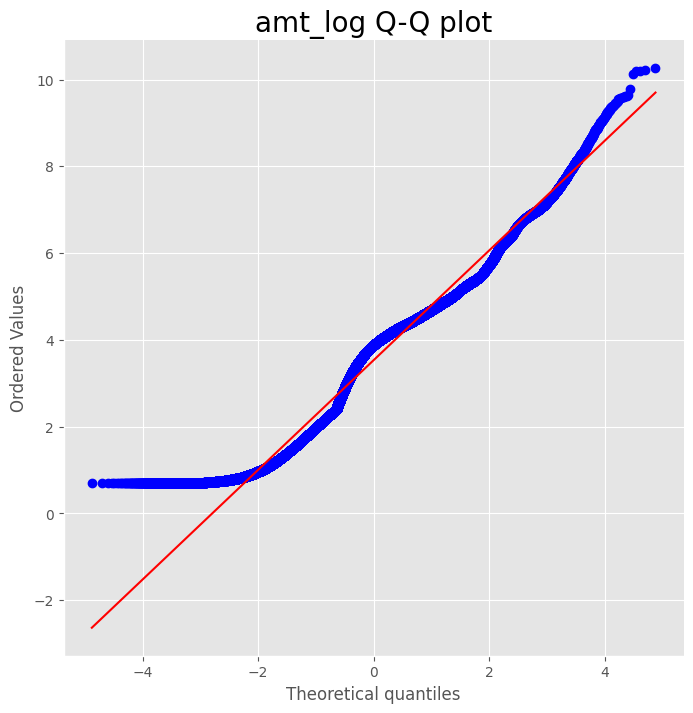

In [20]:
check_normality("amt_log");

## Categorical Encoding

In [21]:
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = train[col]
        y = train[target_col]

        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)

    return train


columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

train = apply_woe(train, columns_to_encode, target_column)

In [22]:
gender_mapping = {"F": 0, "M": 1}

train["gender_binary"] = train["gender"].map(gender_mapping)

In [23]:
train

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,35,0,1,1.79,0.92,-0.16,-2.47,-1.08,0
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,45,0,1,4.68,0.90,-0.12,-3.03,-0.90,0
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,43.15,-112.15,0,61,0,1,5.40,-0.85,-0.99,-1.08,1.12,1
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,47.03,-112.56,0,56,0,1,3.83,-0.21,-0.73,1.75,0.36,1
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,38.67,-78.63,0,37,0,1,3.76,-0.61,0.16,-2.46,-2.46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,entertainment,15.56,M,Hatch,UT,84735,37.72,-112.48,258,Geoscientist,1961-11-24,36.84,-111.69,0,62,12,6,2.81,-0.85,0.00,0.13,-0.05,1
1296671,2020-06-21 12:12:19,6011149206456997,food_dining,51.70,M,Tuscarora,MD,21790,39.27,-77.51,100,"Production assistant, television",1979-12-11,38.91,-78.25,0,44,12,6,3.96,-1.25,0.04,1.08,1.08,1
1296672,2020-06-21 12:12:32,3514865930894695,food_dining,105.93,M,High Rolls Mountain Park,NM,88325,32.94,-105.82,899,Naval architect,1967-08-30,33.62,-105.13,0,56,12,6,4.67,-1.25,-0.14,0.00,0.07,1
1296673,2020-06-21 12:13:36,2720012583106919,food_dining,74.90,M,Manderson,SD,57756,43.35,-102.54,1126,Volunteer coordinator,1980-08-18,42.79,-103.24,0,43,12,6,4.33,-1.25,0.05,-0.27,-0.27,1


In [24]:
freq_enc = (train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
train["cc_num_frequency"] = train["cc_num"].apply(lambda x: freq_enc[x])

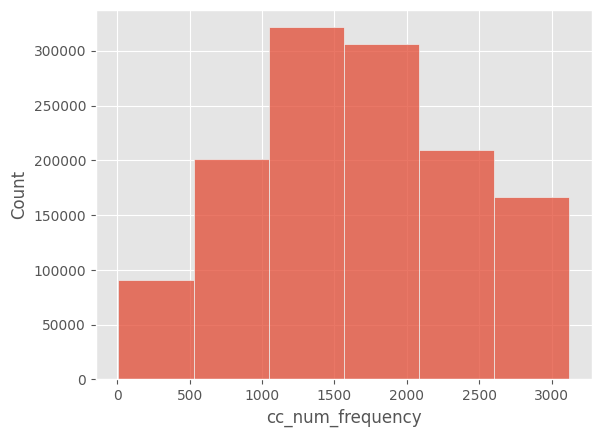

In [25]:
sns.histplot(train["cc_num_frequency"], bins=6);

In [26]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


train["cc_num_frequency_classification"] = train["cc_num_frequency"].apply(
    classify_frequency)

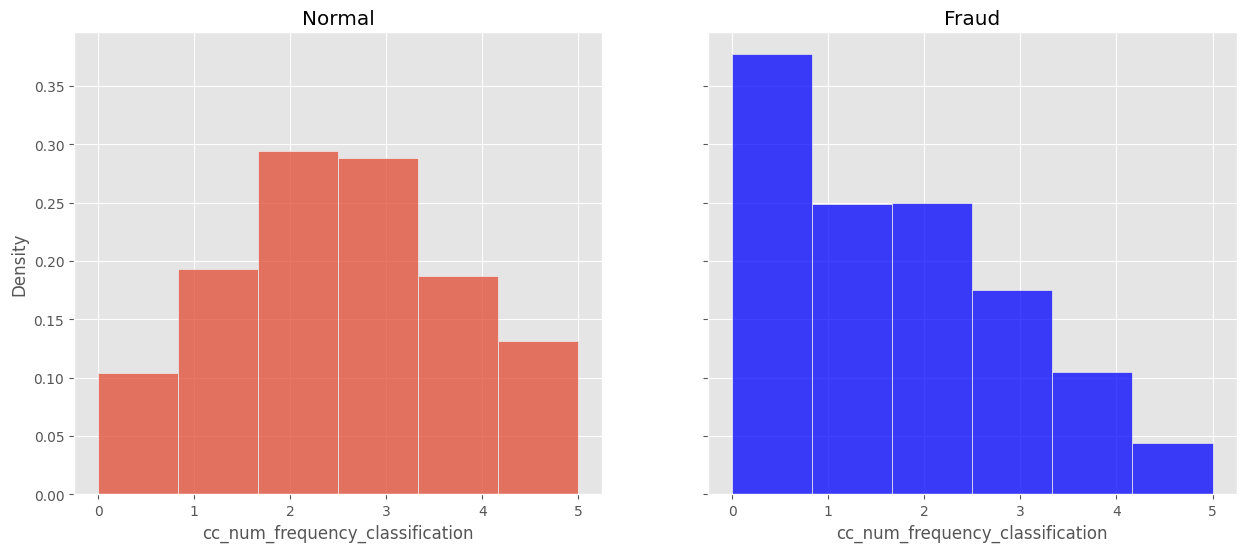

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1)
ax2 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud");

In [50]:
X = train.drop(columns=["is_fraud"])
X = X.drop(columns=["trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])
y = train["is_fraud"]
X

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification
0,28654,36.08,-81.18,3495,36.01,-82.05,35,0,1,1.79,0.92,-0.16,-2.47,-1.08,0,2028,3
1,99160,48.89,-118.21,149,49.16,-118.19,45,0,1,4.68,0.90,-0.12,-3.03,-0.90,0,3030,5
2,83252,42.18,-112.26,4154,43.15,-112.15,61,0,1,5.40,-0.85,-0.99,-1.08,1.12,1,503,0
3,59632,46.23,-112.11,1939,47.03,-112.56,56,0,1,3.83,-0.21,-0.73,1.75,0.36,1,493,0
4,24433,38.42,-79.46,99,38.67,-78.63,37,0,1,3.76,-0.61,0.16,-2.46,-2.46,1,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,84735,37.72,-112.48,258,36.84,-111.69,62,12,6,2.81,-0.85,0.00,0.13,-0.05,1,1513,2
1296671,21790,39.27,-77.51,100,38.91,-78.25,44,12,6,3.96,-1.25,0.04,1.08,1.08,1,531,0
1296672,88325,32.94,-105.82,899,33.62,-105.13,56,12,6,4.67,-1.25,-0.14,0.00,0.07,1,2070,3
1296673,57756,43.35,-102.54,1126,42.79,-103.24,43,12,6,4.33,-1.25,0.05,-0.27,-0.27,1,2024,3


# OverSampling

In [35]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


smote = SMOTE(random_state=23)

# Fit and apply SMOTE only to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X,y)
X_train_resampled

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification
0,28654,36.08,-81.18,3495,36.01,-82.05,35,0,1,1.79,0.92,-0.16,-2.47,-1.08,0,2028,3
1,99160,48.89,-118.21,149,49.16,-118.19,45,0,1,4.68,0.90,-0.12,-3.03,-0.90,0,3030,5
2,83252,42.18,-112.26,4154,43.15,-112.15,61,0,1,5.40,-0.85,-0.99,-1.08,1.12,1,503,0
3,59632,46.23,-112.11,1939,47.03,-112.56,56,0,1,3.83,-0.21,-0.73,1.75,0.36,1,493,0
4,24433,38.42,-79.46,99,38.67,-78.63,37,0,1,3.76,-0.61,0.16,-2.46,-2.46,1,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578333,7640,40.99,-73.98,4664,40.71,-74.00,58,10,1,6.22,0.91,-0.18,0.13,0.22,1,1517,2
2578334,97033,45.08,-120.66,60,44.88,-120.83,81,22,9,6.41,0.92,0.33,0.84,0.84,1,1045,1
2578335,62067,38.93,-89.96,2401,39.59,-90.69,51,22,6,5.52,-1.28,-0.01,0.52,0.57,0,1538,2
2578336,71854,33.43,-93.88,36438,32.88,-93.59,38,7,1,6.53,0.50,-0.11,0.49,-0.29,0,1056,1


# Undersampling

In [51]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)

In [52]:
X_undersampled, y_undersampled = rus.fit_resample(X, y)
X_undersampled

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification
118515,77566,29.04,-95.44,28739,29.24,-95.43,24,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4
598857,12460,42.41,-74.15,277,41.56,-74.09,52,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2
59238,98304,46.75,-121.99,759,46.60,-122.18,67,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1
710180,31042,32.81,-83.17,1841,33.09,-84.14,48,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2
6204,99160,48.89,-118.21,149,48.08,-119.14,45,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,32960,27.63,-80.40,105638,26.89,-80.83,37,1,6,6.89,1.12,0.13,-0.81,-0.64,0,1553,2
1295491,32960,27.63,-80.40,105638,28.22,-79.86,37,1,6,7.10,1.12,0.13,-0.81,-0.64,0,1553,2
1295532,70726,30.46,-90.90,71335,29.70,-91.36,29,2,6,2.42,-0.21,-0.28,-1.60,-0.86,1,2540,4
1295666,79759,31.86,-102.74,23,32.68,-103.48,54,3,6,3.12,-0.21,-0.14,-0.53,-0.90,0,2049,3


In [237]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sampler = Pipeline([('over', SMOTE(sampling_strategy={1:100000}, random_state=42)), ('under', RandomUnderSampler(random_state=42))])
x_sample, y_sample = sampler.fit_resample(X, y)
print(x_sample.shape, y_sample.shape)

(200000, 17) (200000,)


Let's check our proportion after the Undersampling.

In [31]:
import plotly.express as px

labels = ["Genuine", "Fraud"]

fraud_or_not = y_undersampled.value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=values, names=labels, width=700, height=400, color_discrete_sequence=["skyblue", "black"],
             title="Fraud vs Genuine transactions")
fig.show()

# Feature Importance

In [32]:
X_train_resampled["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_train_resampled))
X_train_resampled["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_train_resampled))

NameError: name 'X_train_resampled' is not defined

In [53]:
X_train = X_undersampled
y_train = y_undersampled

In [34]:
X_train.head()

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification
118515,77566,29.04,-95.44,28739,29.24,-95.43,24,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4
598857,12460,42.41,-74.15,277,41.56,-74.09,52,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2
59238,98304,46.75,-121.99,759,46.60,-122.18,67,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1
710180,31042,32.81,-83.17,1841,33.09,-84.14,48,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2
6204,99160,48.89,-118.21,149,48.08,-119.14,45,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5


In [35]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)

Features selected:


['zip',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'hour',
 'month',
 'amt_log',
 'category_WOE',
 'state_WOE',
 'city_WOE',
 'job_WOE',
 'gender_binary',
 'cc_num_frequency',
 'cc_num_frequency_classification']

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
importances = rf.feature_importances_

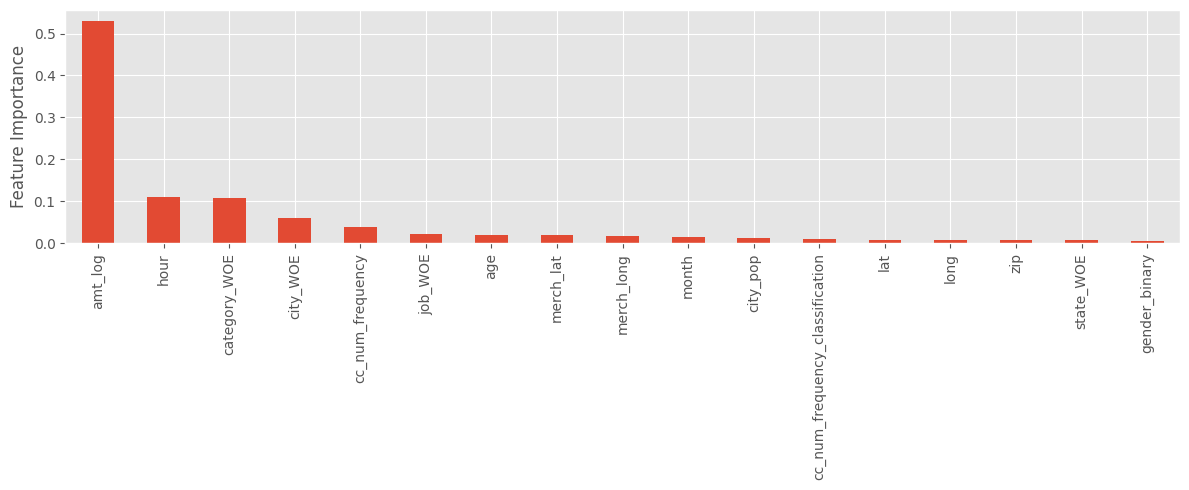

In [37]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

In [54]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                      "city_pop", "month", "cc_num_frequency_classification",
                       "merch_long"],axis = 1, inplace=True)#"random_feat_1", "random_feat_2",

In [55]:
X_train

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
118515,29.24,24,5,3.89,-0.21,0.14,0.35,2556
598857,41.56,52,7,4.65,0.90,0.20,0.70,1548
59238,46.60,67,18,2.39,-0.70,0.77,0.11,1040
710180,33.09,48,5,3.63,-0.61,0.00,-0.23,1548
6204,48.08,45,23,1.42,1.12,-3.03,-0.90,3030
...,...,...,...,...,...,...,...,...
1295399,26.89,37,1,6.89,1.12,-0.81,-0.64,1553
1295491,28.22,37,1,7.10,1.12,-0.81,-0.64,1553
1295532,29.70,29,2,2.42,-0.21,-1.60,-0.86,2540
1295666,32.68,54,3,3.12,-0.21,-0.53,-0.90,2049


# Preparing test data

In [56]:
test = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv", index_col=0)

test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)

test["amt_log"] = np.log1p(test["amt"])

test = apply_woe(test, columns_to_encode, target_column)

test["gender_binary"] = test["gender"].map(gender_mapping)

freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(
    classify_frequency)

X_test = test.drop(columns=["trans_date_trans_time",
                            "city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])

y_test = test["is_fraud"]

X_test.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                     "city_pop", "month", "cc_num_frequency_classification", "merch_long"], inplace=True)

# Training the model

In [57]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

In [51]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
lgbm = LGBMClassifier(random_state=23)

In [52]:
#random forest

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]

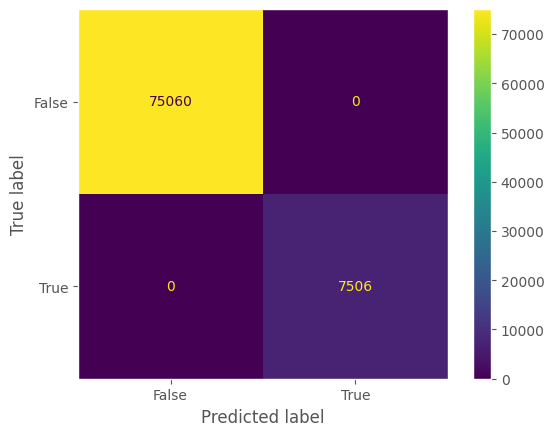

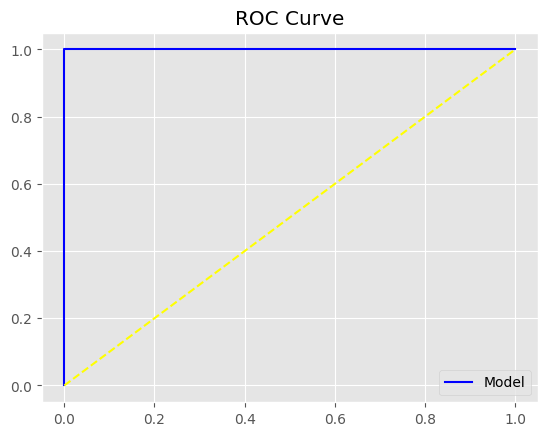

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0000000000000002


In [53]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

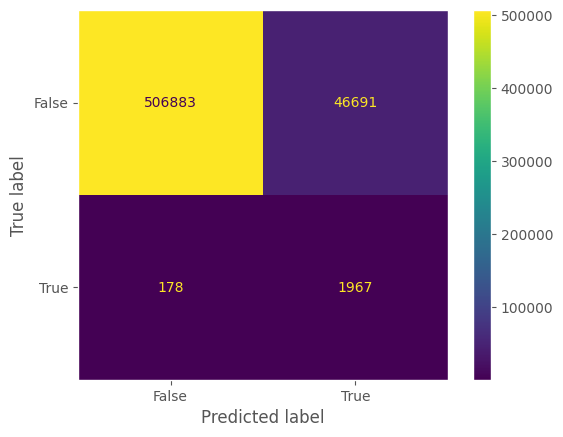

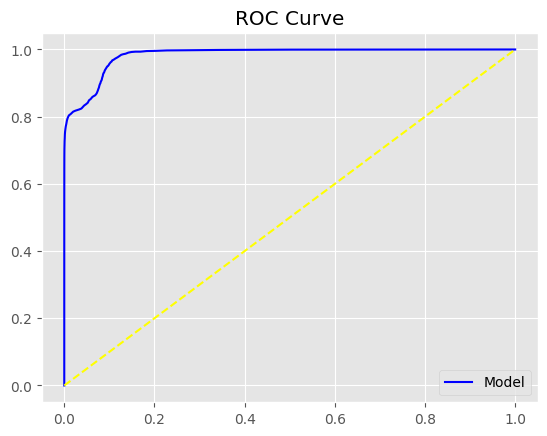

Accuracy 0.92
Precision: 0.04
Recall: 0.92
F1 Score 0.08
AUC: 0.9832345739454817


In [54]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [55]:
#k-nearest neighbors

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]

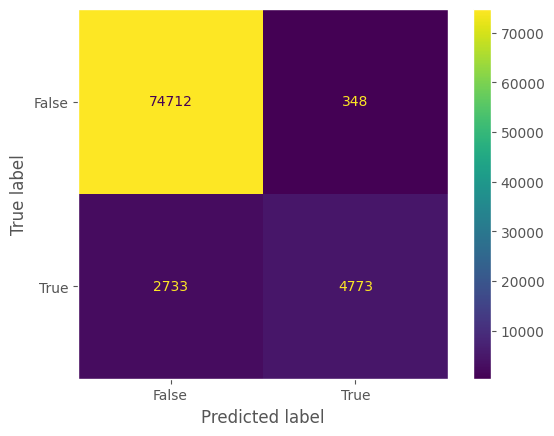

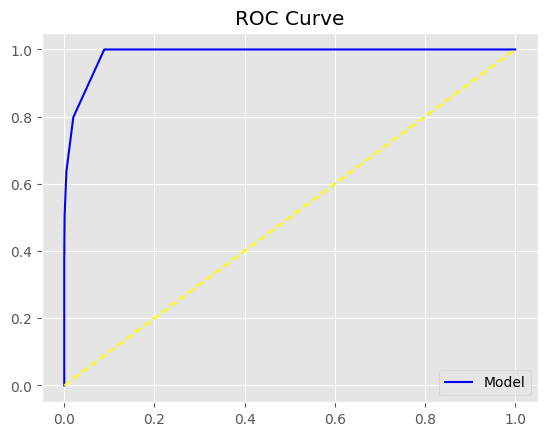

Accuracy 0.96
Precision: 0.93
Recall: 0.64
F1 Score 0.76
AUC: 0.986623736804144


In [56]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

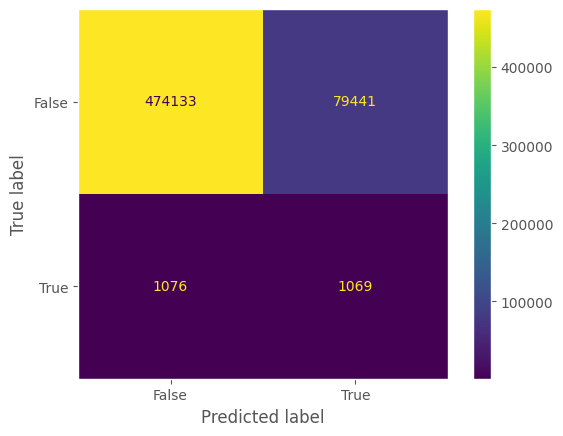

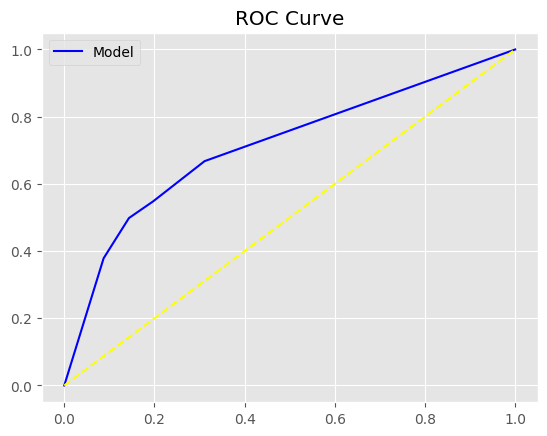

Accuracy 0.86
Precision: 0.01
Recall: 0.5
F1 Score 0.03
AUC: 0.7129069210212834


In [57]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [58]:
#gradient boosting

gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]

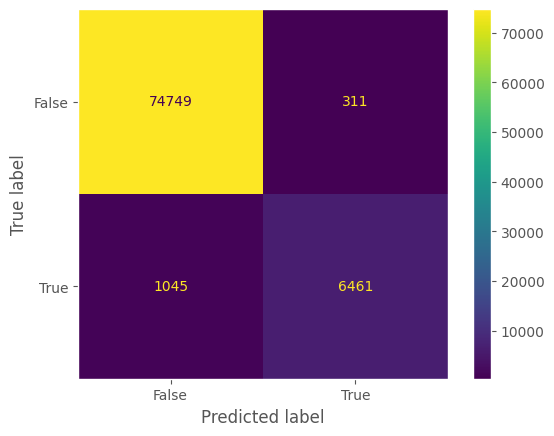

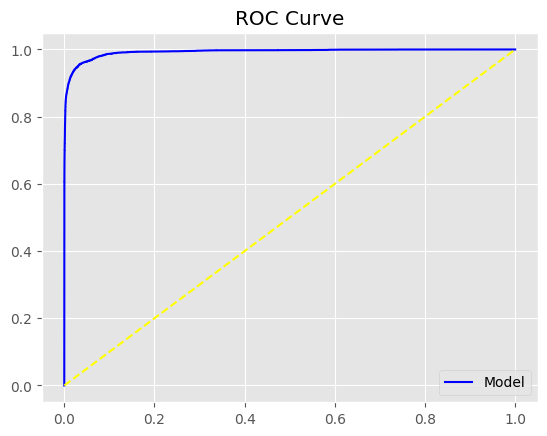

Accuracy 0.98
Precision: 0.95
Recall: 0.86
F1 Score 0.91
AUC: 0.9929958386963047


In [59]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

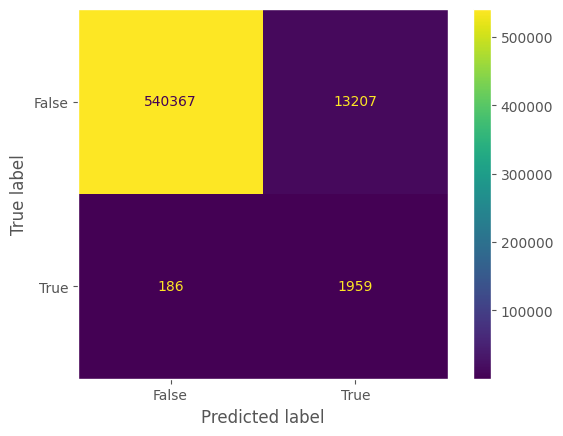

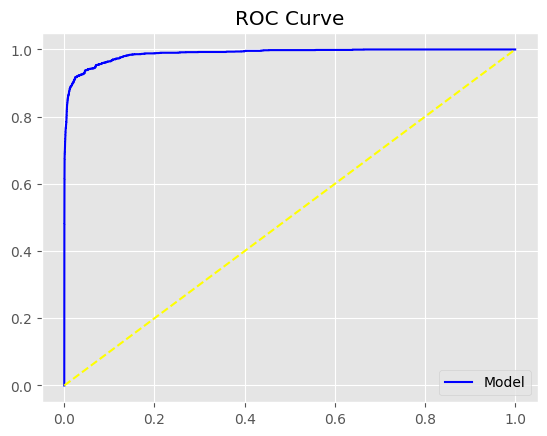

Accuracy 0.98
Precision: 0.13
Recall: 0.91
F1 Score 0.23
AUC: 0.9880523580177104


In [60]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

In [61]:
#LightGBM

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

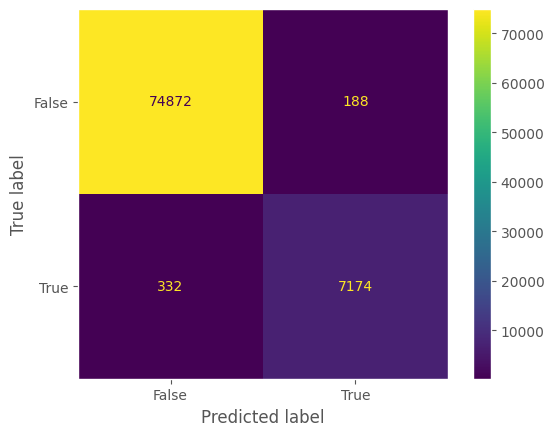

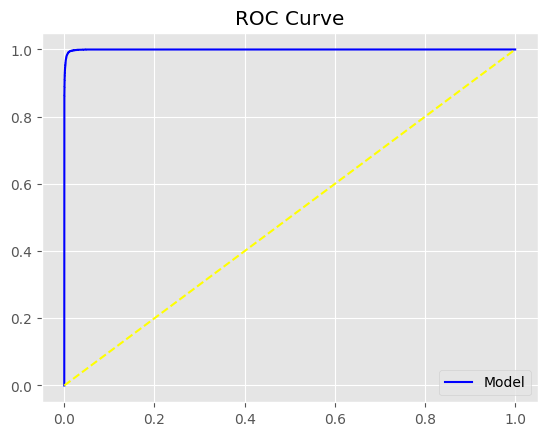

Accuracy 0.99
Precision: 0.97
Recall: 0.96
F1 Score 0.97
AUC: 0.9995715923930187


In [63]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train)

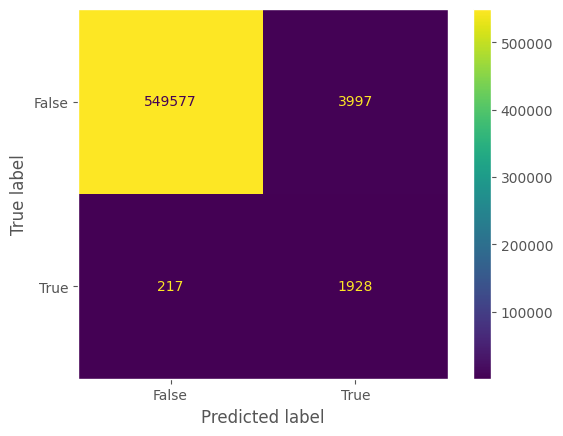

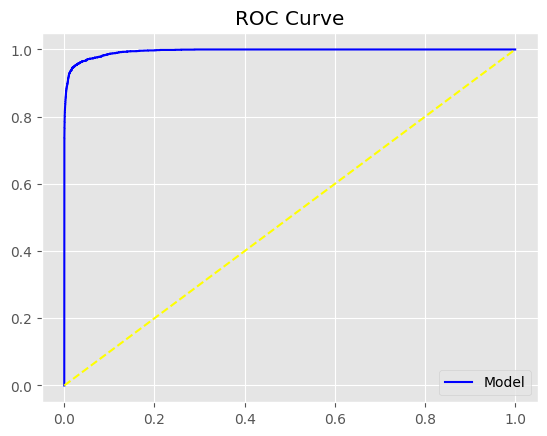

Accuracy 0.99
Precision: 0.33
Recall: 0.9
F1 Score 0.48
AUC: 0.9950190242051854


In [64]:
#test metrics
evaluate_model(y_test, y_pred_test, y_score_test)

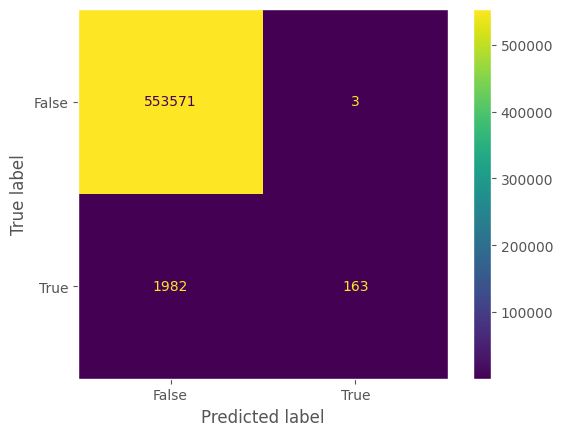

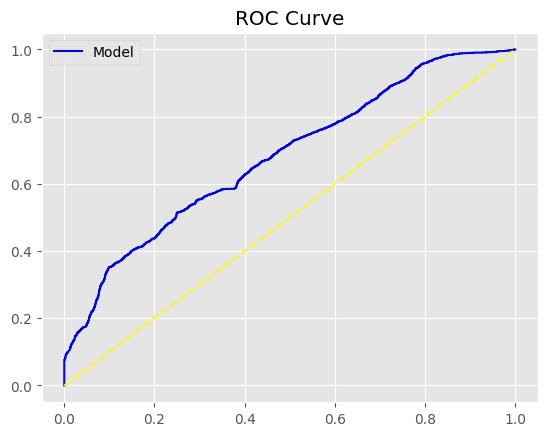

Accuracy 1.0
Precision: 0.98
Recall: 0.08
F1 Score 0.14
AUC: 0.6811894903104029


In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Initialize the SVM model with linear kernel and enable probability estimates
svm_linear = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model on the training data
svm_linear.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_linear.predict(X_test)

# Get probability estimates
y_score_test = svm_linear.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_score_test)

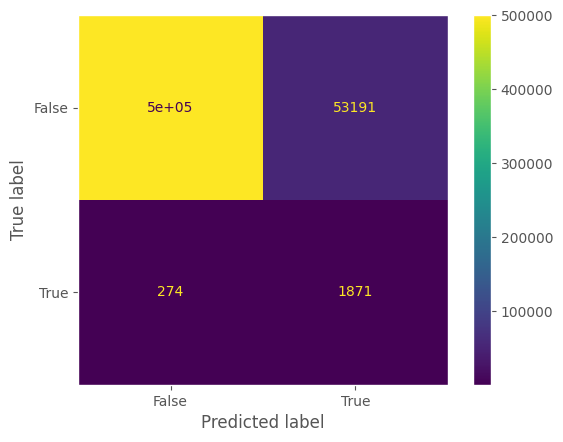

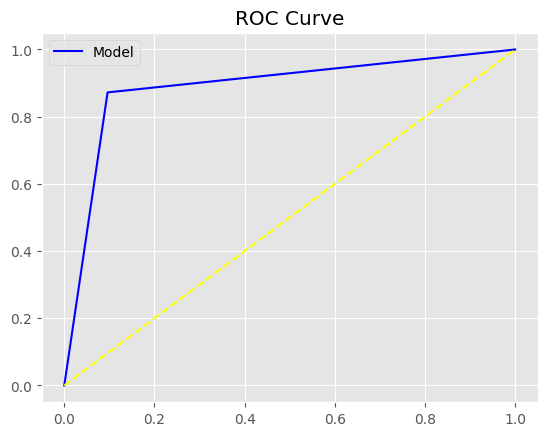

Accuracy 0.9
Precision: 0.03
Recall: 0.87
F1 Score 0.07
AUC: 0.8880872754282632


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

y_score_test = dt_classifier.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_score_test)

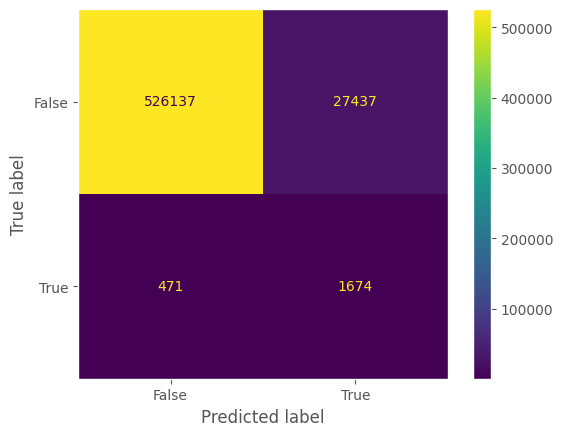

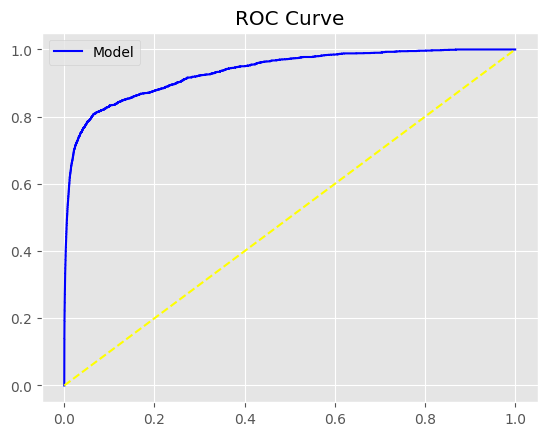

Accuracy 0.95
Precision: 0.06
Recall: 0.78
F1 Score 0.11
AUC: 0.9354240113426779


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

naive_bayes_classifier = GaussianNB()

# Train the model on the training data
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test)

y_score_test = naive_bayes_classifier.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_score_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



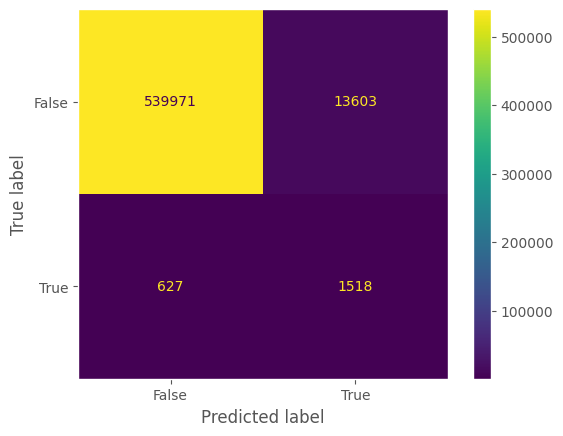

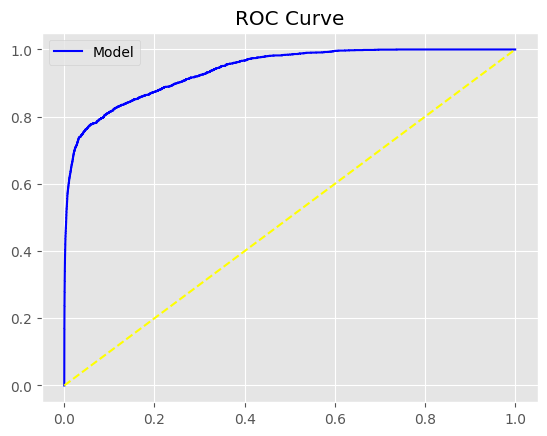

Accuracy 0.97
Precision: 0.1
Recall: 0.71
F1 Score 0.18
AUC: 0.9387797352239324


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
logistic_regression_classifier = LogisticRegression(random_state=42)

# Train the model on the training data
logistic_regression_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_regression_classifier.predict(X_test)

# Get probability estimates for each class
y_prob = logistic_regression_classifier.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_prob)


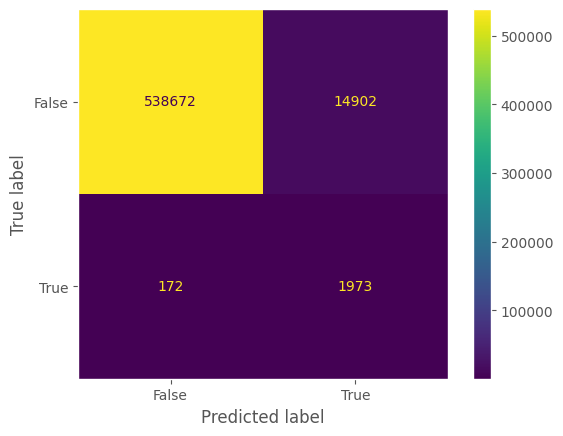

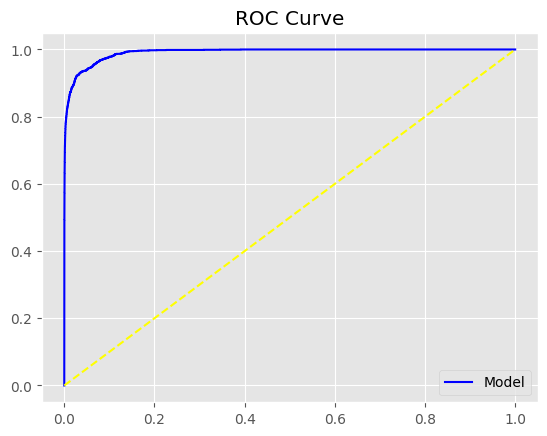

Accuracy 0.97
Precision: 0.12
Recall: 0.92
F1 Score 0.21
AUC: 0.9913526270396354


In [58]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred, y_prob)

# Hyperparameter Tuning

Let's create a function that optimizes our desired metric. Since we can't use accuracy because of the imbalance, we are going to optimize F1 score!

In [295]:
def tune_lgbm(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params)
    
    mdl = LGBMClassifier(learning_rate= learning_rate,
                         num_leaves= num_leaves,
                         min_child_samples= min_child_samples,
                         subsample= subsample,
                         colsample_bytree= colsample_bytree,
                         random_state=23, subsample_freq=1,
                         n_estimators=200)
    
    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_valid)
    
    return -metrics.f1_score(y_valid, y_pred)

In [296]:
space = [(1e-3, 1e-1, "log-uniform"), #learning_rate
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05, 1.0), #subsample
        (0.1, 1.0)] #colsample_bytree

In [297]:
results = gp_minimize(tune_lgbm, space, random_state=23,
                      verbose=1, n_calls=100, n_random_starts=20)

Iteration No: 1 started. Evaluating function at random point.
[0.021786840314037433, 25, 78, 0.5952129636704409, 0.4977223159193984]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.2898
Function value obtained: -0.8425
Current minimum: -0.8425
Iteration No: 2 started. Evaluating function at random point.
[0.002333405878539521, 15, 23, 0.8416721432755412, 0.4840888306663812]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1691
Function value obtained: -0.0040
Current minimum: -0.8425
Iteration No: 3 started. Evaluating function at random point.
[0.03229577569301482, 128, 1, 0.9771571003653318, 0.4772091051979678]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.2267
Function value obtained: -0.8589
Current minimum: -0.8589
Iteration No: 4 started. Evaluating function at random point.
[0.023073573532330794, 97, 58, 0.4251939328278432, 0.5316165472583452]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.

In [298]:
params = results.x
params

[0.1, 128, 100, 1.0, 0.41805573897941306]

In [299]:
learning_rate = params[0]
num_leaves = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]

In [300]:
#LightGBM
lgbm = LGBMClassifier(learning_rate= learning_rate,
                      num_leaves= num_leaves,
                      min_child_samples= min_child_samples,
                      subsample= subsample,
                      colsample_bytree= colsample_bytree,
                      random_state=23, subsample_freq=1,
                      n_estimators=200)

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

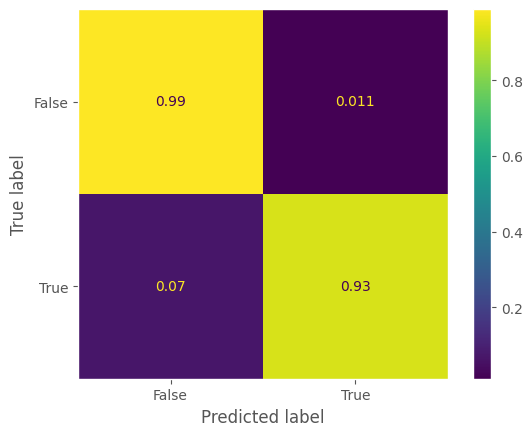

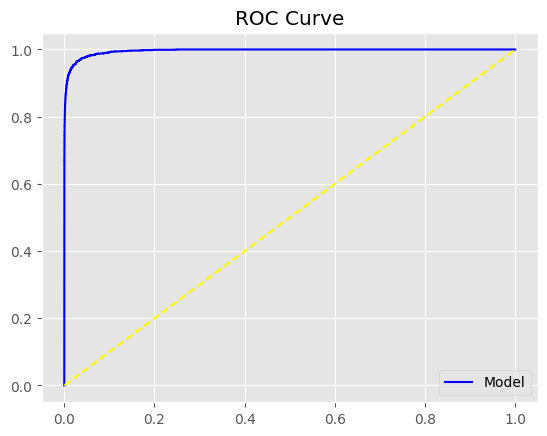

Accuracy 0.99
Precision: 0.24
Recall: 0.93
F1 Score 0.38
AUC: 0.9960178201370887


In [301]:
evaluate_model(y_test, y_pred_test, y_score_test, normalize_matrix="true")

# Conclusion

> In this problem, it is crucial to look at other metrics besides accuracy. As we saw, accuracy is one of the worst metrics for this problem, because of the natural imbalance of the dataset.

> Since our event is related to fraud transactions, i assume the worst cenarios was getting high false negatives (transactions that we identify as non-frauds and ended up being fraudulents). Hence, we used an aproach to consider the recall metric being the most important for the model.

> Also, the precision of the model is very sensitive, because of the target imbalance. As you can see, only 0.71% or normal transactions were false positives, and it dropped the precision to 33%. That is because a small percentage of normal transactions if predicted wrong, means a high number of events compared to the fraud events in dataset.

> The best approach to this problem would be having a way to calculate the mean cost of each false positive and false negative. This way, we could approach this tradeoff with better understanding of how much false positives and false negatives costs for the company.